<a id="title_ID"></a>
# Testing source_catalog step with MIRI simulated data

<span style="color:red"> **Instruments Affected**</span>: FGS, MIRI, NIRCam, NIRISS, NIRSpec 

Tested on MIRI Simulated data

### Table of Contents
<div style="text-align: left"> 

<br>  [Introduction](#intro_ID) <br> [Imports](#imports_ID) <br> [Run Pipeline](#pipeline_ID) <br> [Check Results](#output_ID) <br> [About This Notebook](#about_ID) <br>


</div>

<a id="intro_ID"></a>

## Introduction

This notebook processes an image through calwebb_image2 and calwebb_image3 (calwebb_detector1 is optional) and examines the output table of the source_catalog step. The steps are as follow:

1) Set up data path and directory and image file name.

2) Modify header information of input simulations (if needed).

3) Run input data through calwebb_detector1  (optional).

4) Run output of calwebb_detector1 through calwebb_image2.

5) Run output of calwebb_image2 through calwebb_image3. 

6) Read in output table of source_catalog step and print ecsv table 

7) Display image and overplot detector sources from ecsv table. 

8) Display comparison plot of flux density ratios and concetration indeces.

These steps are set up with simulated MIRI F560W data of the LMC astrometric field.

The pipeline documentation can be found here: https://jwst-pipeline.readthedocs.io/en/latest/jwst/source_catalog/main.html

The pipeline code is available on GitHub: https://github.com/spacetelescope/jwst

Author: T. Temim

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)

<a id="imports_ID"></a>
### Set up import statements

The following packages are needed to enable this notebook to run:
* astropy for coordinate handling and calculations
* jwst to run the pipeline steps and create associations
* matplotlib for plotting
* ci_watson for retrieving data from artifactory

[Top of Page](#title_ID)

In [2]:
import pytest
import numpy as np
from glob import glob
import json
import jwst
from astropy.io import fits, ascii
from astropy.coordinates import Angle
from astropy.table import Table, vstack, unique
from astropy.stats import sigma_clip
from jwst.pipeline import Detector1Pipeline, Image2Pipeline, Image3Pipeline
from jwst.associations import asn_from_list
import matplotlib.pyplot as plt
import random
from jwst import associations
from jwst.datamodels import RampModel
from astropy.io import fits
import numpy as np
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.pipeline import calwebb_image3
from jwst.pipeline import calwebb_image2
from jwst.pipeline import calwebb_detector1
from astropy.io import fits
from jwst.datamodels import ImageModel
from jwst import datamodels
from astropy.utils.data import get_pkg_data_filename
from ci_watson.artifactory_helpers import get_bigdata
from astropy import table

### Print pipeline version number

In [3]:
jwst.__version__ 

'0.18.3'

### Read in data from artifactory

In [4]:
input_file = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'source_catalog',
                     'source_catalog_miri_test', 
                     'det_image_seq1_MIRIMAGE_F560Wexp1_rate.fits')

<a id="pipeline_ID"></a>
## Run Pipelines

Read in the data, check headers and modify if needed, and run the JWST calibration pipelines.

### Read in input image as JWST data model

In [5]:
from jwst import datamodels

im = datamodels.open(input_file)

### Modify header information of input simulations (if needed)

In [6]:
print(im.meta.wcsinfo.wcsaxes)

4


In [7]:
im.meta.wcsinfo.wcsaxes=2

In [8]:
print(im.meta.wcsinfo.wcsaxes)

2


In [9]:
del im.meta.wcsinfo.cdelt3
del im.meta.wcsinfo.crpix3
del im.meta.wcsinfo.crval3
del im.meta.wcsinfo.ctype3
del im.meta.wcsinfo.cunit3
del im.meta.wcsinfo.pc3_1
del im.meta.wcsinfo.pc3_2

### Run input data through calwebb_detector1  (not done here)

In [10]:
#det1 = calwebb_detector1.Detector1Pipeline()
#det1.save_results = True
#det1.run(im)

### Run output of calwebb_detector1 through calwebb_image2

In [11]:
input_file = input_file.replace('rateint.fits', 'rate.fits')

In [12]:
im2 = calwebb_image2.Image2Pipeline()
#im2.background.skip = True
im2.assign_wcs.skip = False
im2.flat_field.skip = False
im2.resample.skip = False
im2.save_results = True
im2.run(im)

2021-03-12 23:32:31,338 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-03-12 23:32:31,339 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-03-12 23:32:31,340 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-03-12 23:32:31,341 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-03-12 23:32:31,342 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-03-12 23:32:31,344 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-03-12 23:32:31,457 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F560Wexp1_rate.fits>,).


2021-03-12 23:32:31,461 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree'

2021-03-12 23:32:31,468 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIMAGE_F560Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-03-12 23:32:32,799 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-03-12 23:32:32,801 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-03-12 23:32:32,801 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-03-12 23:32:32,802 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-03-12 23:32:32,802 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-03-12 23:32:32,802 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-03-12 23:32:32,803 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-03-12 23:32:32,805 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-03-12 23:32:32,805 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-03-12 23:32:32,806 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0561.fits'.


2021-03-12 23:32:32,807 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-03-12 23:32:32,808 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-03-12 23:32:32,808 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-03-12 23:32:32,808 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-03-12 23:32:32,809 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-03-12 23:32:32,809 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-03-12 23:32:32,809 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-03-12 23:32:32,810 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits'.


2021-03-12 23:32:32,811 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-03-12 23:32:32,811 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-03-12 23:32:32,811 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-03-12 23:32:32,812 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-03-12 23:32:32,812 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-03-12 23:32:32,813 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-03-12 23:32:32,844 - stpipe.Image2Pipeline - INFO - Processing product det_image_seq1_MIRIMAGE_F560Wexp1_rate


2021-03-12 23:32:32,844 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F560Wexp1_rate.fits> ...


2021-03-12 23:32:32,977 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F560Wexp1_rate.fits>,).


2021-03-12 23:32:32,979 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-03-12 23:32:33,072 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-03-12 23:32:33,124 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020095696 -0.018350761 0.022563162 0.012836741 359.991504284 0.015409528 359.988697069 -0.015791872


2021-03-12 23:32:33,125 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020095696 -0.018350761 0.022563162 0.012836741 359.991504284 0.015409528 359.988697069 -0.015791872


2021-03-12 23:32:33,125 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-03-12 23:32:33,157 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-03-12 23:32:33,204 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-03-12 23:32:33,336 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F560Wexp1_rate.fits>,).


2021-03-12 23:32:33,337 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-03-12 23:32:33,610 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-03-12 23:32:33,611 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-03-12 23:32:33,612 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-03-12 23:32:33,618 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-03-12 23:32:33,701 - stpipe.Image2Pipeline.flat_field - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:208: RuntimeWarning: invalid value encountered in multiply
  science.var_flat = science.data**2 / flat_data_squared * flat_err**2



2021-03-12 23:32:33,714 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-03-12 23:32:33,842 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F560Wexp1_rate.fits>,).


2021-03-12 23:32:33,843 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-03-12 23:32:33,855 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits


2021-03-12 23:32:33,856 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-03-12 23:32:33,909 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-03-12 23:32:33,909 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-03-12 23:32:33,909 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-03-12 23:32:33,910 - stpipe.Image2Pipeline.photom - INFO -  filter: F560W


2021-03-12 23:32:33,935 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-03-12 23:32:33,937 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-03-12 23:32:33,937 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 1.02701


2021-03-12 23:32:33,945 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-03-12 23:32:34,069 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F560Wexp1_rate.fits>,).


2021-03-12 23:32:34,070 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-03-12 23:32:34,087 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-03-12 23:32:34,904 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-03-12 23:32:35,320 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-03-12 23:32:35,322 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020043795 -0.018546616 0.022794010 0.012792736 359.991423993 0.015545643 359.988673777 -0.015793709


2021-03-12 23:32:35,382 - stpipe.Image2Pipeline.resample - INFO - Saved model in det_image_seq1_MIRIMAGE_F560Wexp1_i2d.fits


2021-03-12 23:32:35,382 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-03-12 23:32:35,383 - stpipe.Image2Pipeline - INFO - Finished processing product det_image_seq1_MIRIMAGE_F560Wexp1_rate


2021-03-12 23:32:35,384 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-03-12 23:32:35,501 - stpipe.Image2Pipeline - INFO - Saved model in det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits


2021-03-12 23:32:35,501 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


[<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits>]

### Run output of calwebb_image2 through calwebb_image3

In [13]:
input_file = input_file.replace('rate.fits', 'cal.fits')

2021-03-12 23:32:35,506 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [14]:
# Read in calibrated file
im = ImageModel(input_file)

# put file into list
calfile = [input_file]

# Put input file into an association table
asn = asn_from_list.asn_from_list(calfile, rule=DMS_Level3_Base, product_name=input_file)

# dump association table to a .json file for use in image3
with open('resampled_image.json', 'w') as fp:
    fp.write(asn.dump()[1])

In [15]:
im3 = calwebb_image3.Image3Pipeline()
im3.tweakreg.skip = False
im3.skymatch.skip = False
im3.outlier_detection.skip = False
im3.resample.skip = False
im3.source_catalog.skip = False
im3.save_results = True
im3.run('resampled_image.json')

2021-03-12 23:32:35,585 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-03-12 23:32:35,591 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2021-03-12 23:32:35,592 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2021-03-12 23:32:35,593 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2021-03-12 23:32:35,595 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2021-03-12 23:32:35,596 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2021-03-12 23:32:35,597 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2021-03-12 23:32:35,598 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2021-03-12 23:32:35,723 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('resampled_image.json',).


2021-03-12 23:32:35,728 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 10.0, 'brightest'

2021-03-12 23:32:35,810 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2021-03-12 23:32:35,815 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf'.


2021-03-12 23:32:35,816 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits'.


2021-03-12 23:32:35,817 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-03-12 23:32:35,818 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2021-03-12 23:32:36,003 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2021-03-12 23:32:36,005 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'global+match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2021-03-12 23:32:36,015 - stpipe.Image3Pipeline.skymatch - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/skymatch/skyimage.py:125: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.mask = np.asanyarray(mask, dtype=np.bool)



2021-03-12 23:32:36,016 - stpipe.Image3Pipeline.skymatch - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/skymatch/skyimage.py:257: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xs = np.linspace(-0.5, nx - 0.5, nintx, dtype=np.float)



2021-03-12 23:32:36,016 - stpipe.Image3Pipeline.skymatch - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/skymatch/skyimage.py:258: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ys = np.linspace(-0.5, ny - 0.5, ninty, dtype=np.float)[1:-1]



2021-03-12 23:32:36,017 - stpipe.Image3Pipeline.skymatch - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/skymatch/skyimage.py:264: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  borderx = np.empty((npts + 1,), dtype=np.float)



2021-03-12 23:32:36,017 - stpipe.Image3Pipeline.skymatch - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/skymatch/skyimage.py:265: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bordery = np.empty((npts + 1,), dtype=np.float)



2021-03-12 23:32:36,022 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-12 23:32:36,022 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2021-03-12 23:32:36.022131


2021-03-12 23:32:36,022 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-12 23:32:36,023 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'global+match'


2021-03-12 23:32:36,023 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2021-03-12 23:32:36,023 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2021-03-12 23:32:36,023 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-12 23:32:36,024 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2021-03-12 23:32:36,024 - stpipe.Image3Pipeline.skymatch - WARNING -    *  Image ID=det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits: Unable to compute sky value


2021-03-12 23:32:36,024 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits. Sky background: 0


2021-03-12 23:32:36,025 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-12 23:32:36,025 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing "global" sky - smallest sky value across *all* input images.


2021-03-12 23:32:36,047 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-12 23:32:36,047 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: 0.9046948509764708 [not converted]


2021-03-12 23:32:36,048 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-12 23:32:36,048 - stpipe.Image3Pipeline.skymatch - INFO - ----  Final (match+global) sky for:


2021-03-12 23:32:36,048 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits. Sky background: 0.904695 (old=0, delta=0.904695)


2021-03-12 23:32:36,048 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-12 23:32:36,049 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2021-03-12 23:32:36.048992


2021-03-12 23:32:36,049 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:00.026861


2021-03-12 23:32:36,049 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-03-12 23:32:36,050 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2021-03-12 23:32:36,168 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2021-03-12 23:32:36,170 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-03-12 23:32:36,176 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-03-12 23:32:36,255 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp5ea52u8w/det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits


2021-03-12 23:32:37,418 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-03-12 23:32:37,861 - stpipe.Image3Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-03-12 23:32:37,864 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020043795 -0.018546616 0.022794010 0.012792736 359.991423993 0.015545643 359.988673777 -0.015793709


2021-03-12 23:32:38,195 - stpipe.Image3Pipeline.resample - INFO - Saved model in det_image_seq1_MIRIMAGE_F560Wexp1_i2d.fits


2021-03-12 23:32:38,196 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2021-03-12 23:32:38,345 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1023, 1023) from det_image_seq1_MIRIMAGE_F560Wexp1_i2d.fits>,).


2021-03-12 23:32:38,347 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 2.0, 'snr_threshold': 3.0, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2021-03-12 23:32:38,356 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits


2021-03-12 23:32:38,358 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file /grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf


2021-03-12 23:32:38,359 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2021-03-12 23:32:38,359 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2021-03-12 23:32:38,359 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F560W


2021-03-12 23:32:38,360 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2021-03-12 23:32:38,388 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 3.76066


2021-03-12 23:32:38,839 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 1620 sources


2021-03-12 23:32:51,726 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: det_image_seq1_MIRIMAGE_F560Wexp1_cat.ecsv


2021-03-12 23:32:51,733 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2021-03-12 23:32:51,734 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


<a id="output_ID"></a>
## Results
Read in the output of the pipeline and check your results.

### Read in output table of source_catalog step and print ecsv table

In [16]:
photfile = input_file.replace('cal.fits','cat.ecsv')
input_file = input_file.replace('cal.fits', 'i2d.fits')

2021-03-12 23:32:51,738 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [17]:
data = table.Table.read(photfile, format='ascii', comment='#')
print(data)

 id  xcentroid ...                 sky_bbox_ur                
        pix    ...                   deg,deg                  
---- --------- ... -------------------------------------------
   1  706.7194 ...      359.9981088446823,-0.01620453132456754
   2  762.2140 ...     359.99650082370033,-0.01621792219139828
   3  948.8558 ...    359.99074930983807,-0.015558687686007246
   4 1009.4176 ...     359.9888045408072,-0.014831806589005342
   5 1018.8983 ...    359.98873457445023,-0.015629089471152893
   6  535.6835 ... 0.0035483294408072494,-0.016898184955317842
   7  544.4231 ... 0.0016822276537302359,-0.012810011518925855
   8  628.4063 ...  0.0007325563407773196,-0.01658928220577387
   9  916.2710 ...    359.99187314071173,-0.015780914168247825
  10  936.0467 ...    359.99128781986826,-0.015760449599408605
 ...       ... ...                                         ...
1611  258.0218 ...   0.014489782728601274,0.013413328803527408
1612  618.0521 ...  0.0036705153625505396,0.01442458617

### Display image and overplot detector sources from ecsv table 

In [18]:
# Read in i2d combined Image
im_i2d = ImageModel(input_file)    

2021-03-12 23:32:52,036 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



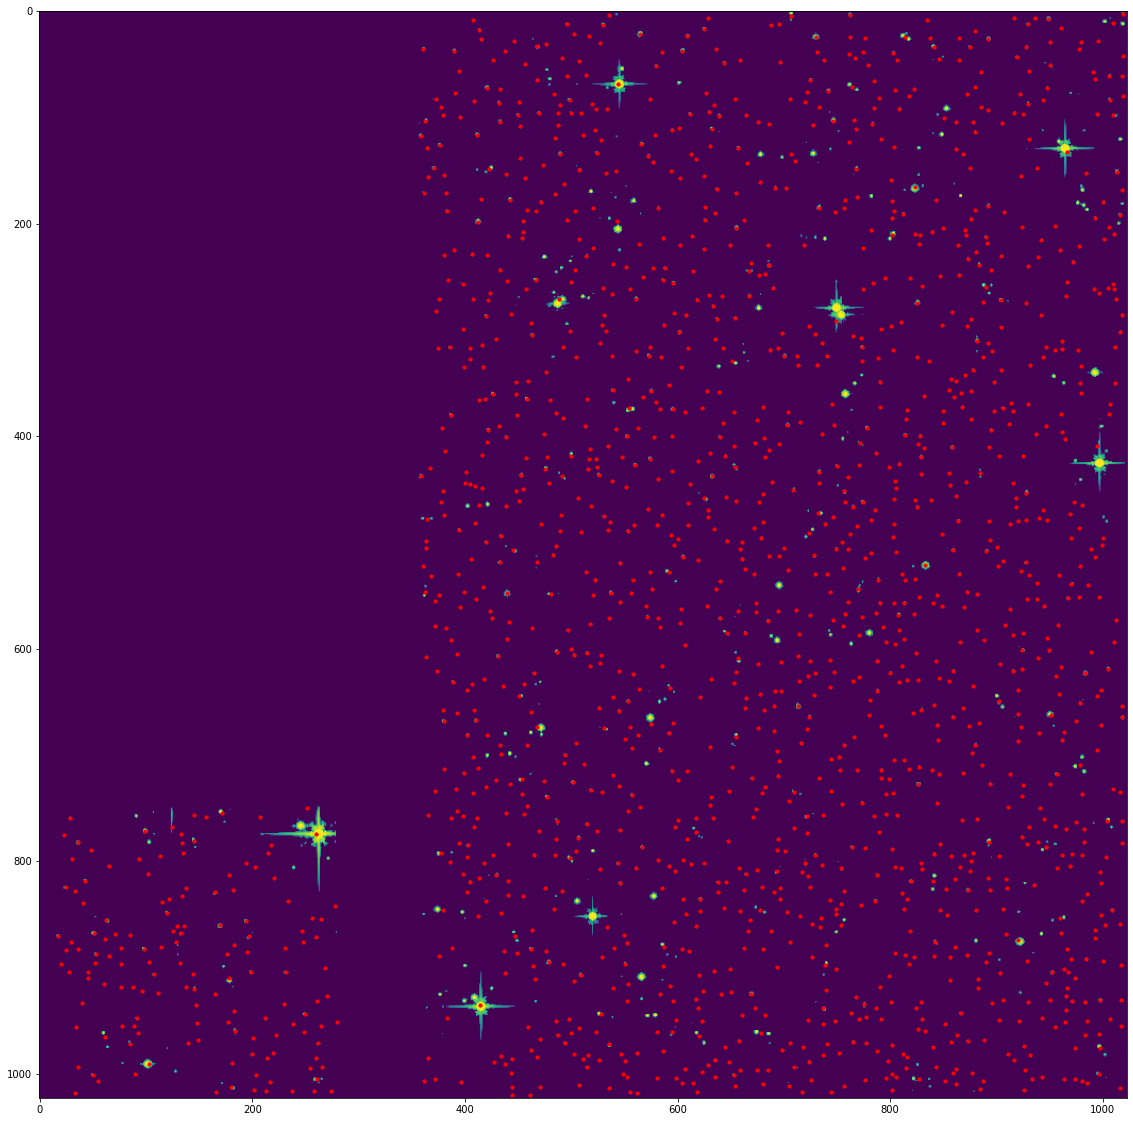

In [19]:
# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval
from astropy import table

viz2 = LogStretch() + ManualInterval(1,15)

plt.figure(figsize=(20,20))
plt.imshow(viz2(im_i2d.data))
plt.scatter(data['xcentroid'], data['ycentroid'],lw=1, s=10,color='red')

### In the image above, check that the stars found by source catalog (red) overlap with stars in the image

### Display comparison plot of flux density ratios and concetration indeces

2021-03-12 23:32:52,447 - stpipe - WARNING - <ipython-input-1-99e49db0de2d>:1: RuntimeWarning: invalid value encountered in log10
  xaxis= -2.5*np.log10(data['aper30_flux']/data['aper50_flux'])



2021-03-12 23:32:52,448 - stpipe - WARNING - <ipython-input-1-99e49db0de2d>:2: RuntimeWarning: invalid value encountered in log10
  yaxis= -2.5*np.log10(data['aper50_flux']/data['aper70_flux'])



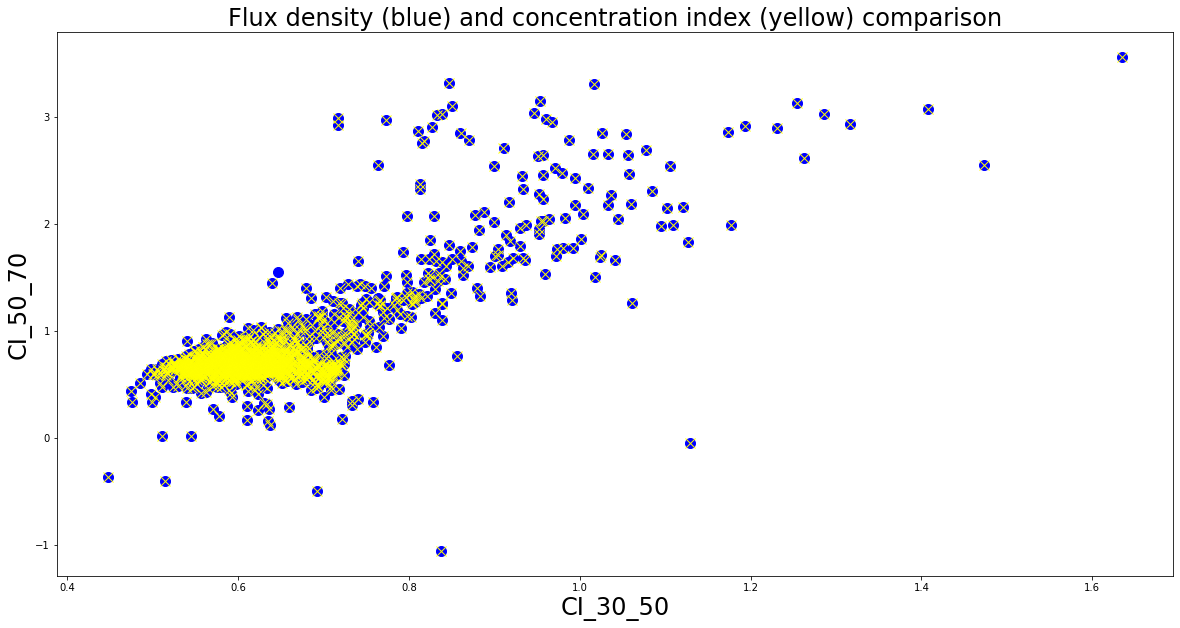

In [20]:
xaxis= -2.5*np.log10(data['aper30_flux']/data['aper50_flux'])
yaxis= -2.5*np.log10(data['aper50_flux']/data['aper70_flux'])

xaxis2=data['CI_30_50']
yaxis2=data['CI_50_70']

plt.figure(figsize=(20,10))

plt.xlabel('CI_30_50',fontsize=24)
plt.ylabel('CI_50_70',fontsize=24)

plt.plot(xaxis,yaxis, marker='o',linestyle='',markersize=10, color='blue') #ylim=(30000,40000))
plt.plot(xaxis2,yaxis2, marker='x',linestyle='',markersize=10,color='yellow')
#plt.savefig(dir+'testphot.png')
plt.title('Flux density (blue) and concentration index (yellow) comparison',fontsize=24)
#plt.xlabel('f50/f30',fontsize=24)
#plt.ylabel('f70/f50',fontsize=24)
#plt.axis([1.4, 2.2, 1.0, 4.5])
plt.show()

### In the plot above, the measured flux densities (blue) and concentration indices (yellow) should overlap

### Note: Additional tests for other parameters in the source catalog output will be added (e.g. astrometry, etc.)